In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GM
import ipinfo
import pickle

In [6]:
# pinfo setup
access_token = '1333a16017c88b'
handler = ipinfo.getHandler(access_token)

In [5]:
df = pd.read_csv('ssh-logs.csv')
df.time = pd.to_datetime(df.time, format='%Y-%m-%dT%H:%M:%S', utc=True)

In [6]:
df.head()

,time,client_version,user,fingerprint,src,password
0,2017-02-08 00:30:27+00:00,SSH-2.0-sshlib-0.1,root,NaN,60.160.226.redacted,12345
1,2017-02-08 01:11:17+00:00,SSH-2.0-Go,admin,NaN,177.42.196.redacted,smcadmin
2,2017-02-08 01:56:09+00:00,SSH-2.0-sshlib-0.1,root,NaN,79.98.0.redacted,password
3,2017-02-08 20:07:33+00:00,SSH-2.0-Go,support,NaN,5.200.54.redacted,password
4,2017-02-09 04:55:19+00:00,SSH-2.0-sshlib-0.1,root,NaN,120.42.100.redacted,111111


# geocode IP addresses

In [28]:
dict_geo = {}

In [47]:
for i, src in enumerate(df.src.unique()):
    ip = src[:-len('.redacted')] + '.1'
    details = handler.getDetails(ip)
    dict_geo[src] = (details.city, details.country)
    
dict_geo

4492 190.152.105.redacted
4493 59.88.160.redacted
4494 88.147.203.redacted
4495 101.108.120.redacted
4496 188.16.111.redacted
4497 181.196.221.redacted
4498 154.126.85.redacted
4499 190.152.196.redacted
4500 49.248.87.redacted
4501 191.110.154.redacted
4502 186.130.81.redacted
4503 181.21.128.redacted
4504 190.50.158.redacted
4505 187.18.89.redacted
4506 188.17.5.redacted
4507 171.78.155.redacted
4508 186.135.152.redacted
4509 181.27.151.redacted


{'60.160.226.redacted': ('Kunming', 'CN'),
 '177.42.196.redacted': ('Salvador', 'BR'),
 '79.98.0.redacted': ('Cremona', 'IT'),
 '5.200.54.redacted': ('Saint Petersburg', 'RU'),
 '120.42.100.redacted': ('Xiamen', 'CN'),
 '105.157.52.redacted': ('Casablanca', 'MA'),
 '177.204.221.redacted': ('Pinhais', 'BR'),
 '189.243.127.redacted': ('Morelia', 'MX'),
 '184.91.189.redacted': ('Palm Bay', 'US'),
 '190.233.11.redacted': ('Lima', 'PE'),
 '93.201.188.redacted': ('Ulm', 'DE'),
 '110.84.29.redacted': ('Xiamen', 'CN'),
 '191.34.15.redacted': ('Rio de Janeiro', 'BR'),
 '117.248.40.redacted': ('Kallakurichi', 'IN'),
 '113.153.122.redacted': ('Osaka', 'JP'),
 '193.90.12.redacted': ('Vikevåg', 'NO'),
 '189.165.18.redacted': ('Puebla', 'MX'),
 '191.207.2.redacted': ('Fortaleza', 'BR'),
 '184.73.149.redacted': ('Ashburn', 'US'),
 '110.77.210.redacted': ('Nakhon Sawan', 'TH'),
 '190.6.110.redacted': ('Rafaela', 'AR'),
 '103.57.72.redacted': ('Stockholm', 'SE'),
 '179.158.101.redacted': ('Rio de Janei

In [3]:
with open('dict_geo.pickle', 'rb') as handle:
    dict_geo = pickle.load(handle)

df_geo = pd.DataFrame(dict_geo).T
df_geo.columns = ['city', 'country']
df_geo.head()

,city,country
60.160.226.redacted,Kunming,CN
177.42.196.redacted,Salvador,BR
79.98.0.redacted,Cremona,IT
5.200.54.redacted,Saint Petersburg,RU
120.42.100.redacted,Xiamen,CN


In [7]:
df = df.join(df_geo, 'src')
df.head()

,time,client_version,user,fingerprint,src,password,city,country
0,2017-02-08 00:30:27+00:00,SSH-2.0-sshlib-0.1,root,NaN,60.160.226.redacted,12345,Kunming,CN
1,2017-02-08 01:11:17+00:00,SSH-2.0-Go,admin,NaN,177.42.196.redacted,smcadmin,Salvador,BR
2,2017-02-08 01:56:09+00:00,SSH-2.0-sshlib-0.1,root,NaN,79.98.0.redacted,password,Cremona,IT
3,2017-02-08 20:07:33+00:00,SSH-2.0-Go,support,NaN,5.200.54.redacted,password,Saint Petersburg,RU
4,2017-02-09 04:55:19+00:00,SSH-2.0-sshlib-0.1,root,NaN,120.42.100.redacted,111111,Xiamen,CN


# fingerprint analysis

In [8]:
df[df.drop('fingerprint', axis=1).isna().any(axis=1)]

,time,client_version,user,fingerprint,src,password,city,country
41,2017-02-17 22:38:17+00:00,SSH-2.0-libssh-0.5.2,root,NaN,223.114.27.redacted,NaN,Korla,CN
60,2017-02-21 12:49:30+00:00,SSH-2.0-kthrssh__x00,root,SHA256:+UJNIlXcTgv4BLeaZTgWpOCGtI+pQH//L2cG5GR...,189.135.22.redacted,NaN,Sahuayo de Morelos,MX
1227,2017-03-17 12:37:28+00:00,SSH-2.0-OpenSSH_6.6.1,lr339r,SHA256:NdVr8EeToEpb2Whibh8vVaoJhZxy3OmcdJ0e/lx...,129.42.208.redacted,NaN,Durham,US
1645,2017-03-22 11:42:32+00:00,SSH-2.0-Go,root,NaN,42.116.90.redacted,NaN,Ho Chi Minh City,VN
1855,2017-03-24 05:22:38+00:00,SSH-2.0-Go,admin,NaN,167.205.25.redacted,NaN,Bandung,ID
2029,2017-03-26 13:13:32+00:00,SSH-2.0-Go,admin,NaN,79.200.223.redacted,NaN,Dessau,DE
3493,2017-03-28 23:23:55+00:00,SSH-2.0-Go,root,NaN,178.4.177.redacted,NaN,Saarbrücken,DE
3564,2017-03-29 00:39:22+00:00,SSH-2.0-libssh-0.5.2,admin,NaN,190.115.139.redacted,NaN,Port-au-Prince,HT
3963,2017-03-29 06:57:54+00:00,SSH-2.0-Go,admin,NaN,14.20.113.redacted,NaN,Shenzhen,CN
3964,2017-03-29 06:59:05+00:00,SSH-2.0-Go,root,NaN,113.6.252.redacted,NaN,Harbin,CN


observation: if fingerprint is present then password is NaN

# calculate inter-attack time

In [9]:
def f(group):
    group = group.sort_values('time')
    t = group.time.values.astype('datetime64[s]')
    dt = np.zeros(len(group))
    dt[1:] = pd.Series(t[1:] - t[:-1]).dt.seconds
    dt[0] = None
    return pd.Series(dt, index=group.index)

grouped = df.groupby('src').apply(f)
grouped

src                     
1.10.132.redacted   8456       NaN
1.10.158.redacted   9032       NaN
1.164.129.redacted  8530       NaN
1.171.56.redacted   4892       NaN
1.172.95.redacted   6135       NaN
                             ...  
99.14.31.redacted   2472    1218.0
                    2473     491.0
                    2476     539.0
                    2477      46.0
99.69.22.redacted   2057       NaN
Length: 10015, dtype: float64

In [10]:
dt = grouped.reset_index(level='src')[0].rename('dt')
df = df.join(dt)
df.head()

,time,client_version,user,fingerprint,src,password,city,country,dt
0,2017-02-08 00:30:27+00:00,SSH-2.0-sshlib-0.1,root,NaN,60.160.226.redacted,12345,Kunming,CN,NaN
1,2017-02-08 01:11:17+00:00,SSH-2.0-Go,admin,NaN,177.42.196.redacted,smcadmin,Salvador,BR,NaN
2,2017-02-08 01:56:09+00:00,SSH-2.0-sshlib-0.1,root,NaN,79.98.0.redacted,password,Cremona,IT,NaN
3,2017-02-08 20:07:33+00:00,SSH-2.0-Go,support,NaN,5.200.54.redacted,password,Saint Petersburg,RU,NaN
4,2017-02-09 04:55:19+00:00,SSH-2.0-sshlib-0.1,root,NaN,120.42.100.redacted,111111,Xiamen,CN,NaN


# Clustering

In [129]:
dt = df.set_index('src', append=True).dt.dropna() #.fillna(0)

lg_dt = dt # np.log(dt + .0001)
lg_dt_agg = lg_dt.groupby('src').agg(['median', 'std', 'count']).fillna(0)
lg_dt_agg.columns = [f'dt_{col}' for col in lg_dt_agg.columns]

kmeans = KMeans(n_clusters=2).fit(lg_dt_agg)
lg_dt_agg['label'] = kmeans.labels_
lg_dt_agg

,dt_median,dt_std,dt_count,label
src,,,,
1.192.241.redacted,14.0,0.000000,1,0
1.24.230.redacted,16104.0,0.000000,1,0
1.83.54.redacted,25850.0,0.000000,1,0
101.109.152.redacted,64430.0,0.000000,1,1
101.109.36.redacted,1.5,2.121320,2,0
...,...,...,...,...
95.83.62.redacted,57592.5,26947.132324,2,1
96.231.239.redacted,1350.0,298.436481,3,0
96.80.83.redacted,242.0,2122.424086,3,0


In [13]:
df_subset = df
dt = df_subset.set_index('src', append=True).dt.dropna()

dt_agg = dt.groupby('src').agg(['median', 'count'])
dt_agg.columns = [f'dt_{col}' for col in dt_agg.columns]
dt_agg.head()

lg_dt_agg = np.log(dt_agg+.0001).fillna(0)
gm = GM(n_components=4).fit(lg_dt_agg)
lg_dt_agg['label'] = gm.predict(lg_dt_agg)
lg_dt_agg.head()

,dt_median,dt_count
src,,
1.192.241.redacted,14.0,1
1.24.230.redacted,16104.0,1
1.83.54.redacted,25850.0,1
101.109.152.redacted,64430.0,1
101.109.36.redacted,1.5,2


16


Text(0, 0.5, 'count')

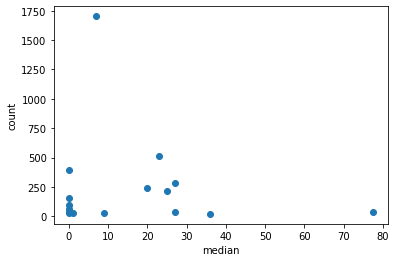

In [26]:
df_sub = dt_agg[dt_agg.dt_count >= 20]
print(len(df_sub))
plt.scatter(df_sub.dt_median, df_sub.dt_count)
plt.xlabel('median')
plt.ylabel('count')

In [275]:
dt_agg[dt_agg.dt_count > 100]

,dt_median,dt_count
src,,
119.252.161.redacted,7.0,1703
121.18.238.redacted,23.0,511
221.194.44.redacted,27.0,280
221.194.47.redacted,25.0,213
223.99.60.redacted,0.0,157
42.7.26.redacted,20.0,243
61.177.172.redacted,0.0,397


Text(0.5, 0, 'count')

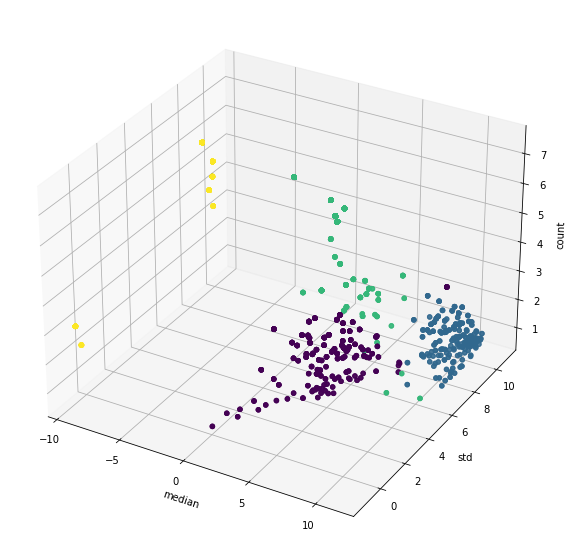

In [158]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
# pd.factorize(lg_dt_agg.country)[0]
ax.scatter3D(lg_dt_agg.dt_median, lg_dt_agg.dt_std, lg_dt_agg.dt_count, c=lg_dt_agg.label)
ax.set_xlabel('median')
ax.set_ylabel('std')
ax.set_zlabel('count')

## distribution of inter-attack times

Text(0, 0.5, 'cmf')

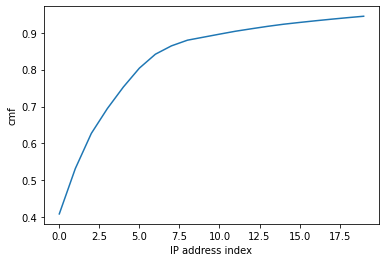

In [413]:
counts = df.groupby('src').dt.count().sort_values(ascending=False)
counts = counts[counts > 10]
cumulative = np.cumsum(counts) / counts.sum()
cumulative = cumulative[:20]
plt.plot(np.arange(len(cumulative)), cumulative)
plt.xlabel('IP address index')
plt.ylabel('cmf')

In [341]:
cumulative[7]

0.864280566898871

In [342]:
counts.head(8)

src
119.252.161.redacted    1703
121.18.238.redacted      511
61.177.172.redacted      397
221.194.44.redacted      280
42.7.26.redacted         243
221.194.47.redacted      213
223.99.60.redacted       157
218.65.30.redacted        94
Name: dt, dtype: int64

In [390]:
import scipy.stats as ss

def fit_dt(src, thresh, a=1):
    dt_select = df[df.src == src].dt.dropna()
    dt_select = dt_select[dt_select < thresh]

    P = ss.expon.fit(dt_select)

    plt.hist(dt_select, bins=20, density=True, label='hist', alpha=a)

    x = np.linspace(0, thresh)
    y = ss.expon.pdf(x, *P)
    plt.plot(x,y, label='exp fit')

    return P[1], ss.percentileofscore(dt, thresh)


user                             oracle
password                         oracle
client_version    SSH-2.0-libssh2_1.7.0
city                          Tangerang
country                              ID
Name: 3980, dtype: object


(9.109178164367126, 97.94480328831474)

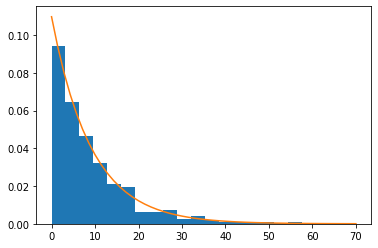

In [411]:
src = '119.252.161.redacted'
print(df[df.src == src].iloc[0][['user', 'password', 'client_version', 'city', 'country']])
dt = df[df.src == src].dt.dropna()
fit_dt(src, 70)
# plt.xlabel('inter-attack time')
# plt.ylabel('density')
# plt.legend()

Text(0, 0.5, 'inter-attack time')

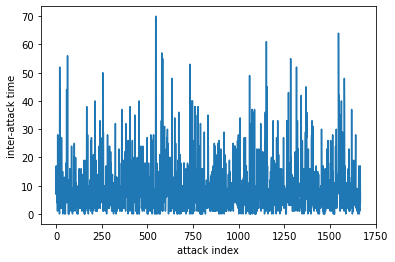

In [346]:
dt = dt[dt <= 70]
plt.plot(np.arange(len(dt)), dt)
plt.xlabel('attack index')
plt.ylabel('inter-attack time')

user                       root
password                 itachi
client_version    SSH-2.0-PUTTY
city               Shijiazhuang
country                      CN
Name: 6359, dtype: object


(29.623318385650226, 87.27984344422701)

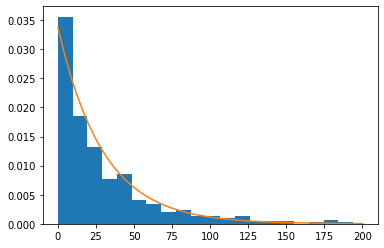

In [412]:
src = '121.18.238.redacted'
print(df[df.src == src].iloc[0][['user', 'password', 'client_version', 'city', 'country']])
# print(df[df.src == src].user.unique(), df[df.src == src].password.unique())
dt = df[df.src == src].dt.dropna()
fit_dt(src, 200)
# plt.xlabel('inter-attack time')
# plt.ylabel('density')
# plt.legend()

user                                        root
password                                   wubao
client_version    SSH-2.0-OpenSSH_6.2p2 Ubuntu-6
city                                     Nanjing
country                                       CN
Name: 601, dtype: object


Text(0, 0.5, 'count')

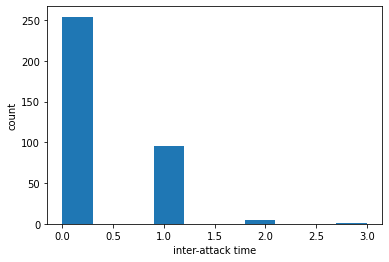

In [363]:
src = '61.177.172.redacted'
print(df[df.src == src].iloc[0][['user', 'password', 'client_version', 'city', 'country']])
dt = df[df.src == src].dt.dropna()
# fit_dt(src, 3)

plt.hist(dt[dt <= 3])
plt.xlabel('inter-attack time')
plt.ylabel('count')

Text(0, 0.5, 'inter-attack time')

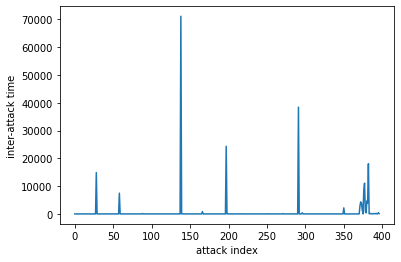

In [355]:
dt = df[df.src == src].dt.dropna()
plt.plot(np.arange(len(dt)), dt)
plt.xlabel('attack index')
plt.ylabel('inter-attack time')

user                       root
password                   root
client_version    SSH-2.0-PUTTY
city               Shijiazhuang
country                      CN
Name: 5737, dtype: object


(30.681614349775785, 79.64285714285714)

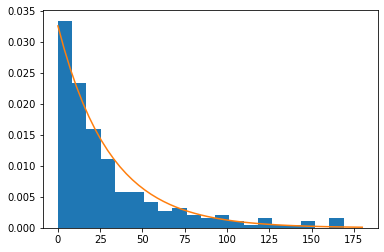

In [410]:
src = '221.194.44.redacted'
print(df[df.src == src].iloc[0][['user', 'password', 'client_version', 'city', 'country']])
dt = df[df.src == src].dt.dropna()
fit_dt(src, 180)
# plt.xlabel('inter-attack time')
# plt.ylabel('density')
# plt.legend()

user                       root
password                   root
client_version    SSH-2.0-PUTTY
city                    Tianjin
country                      CN
Name: 6353, dtype: object


(23.54679802955665, 83.53909465020575)

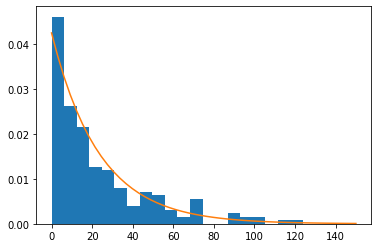

In [409]:
src = '42.7.26.redacted'
print(df[df.src == src].iloc[0][['user', 'password', 'client_version', 'city', 'country']])
dt = df[df.src == src].dt.dropna()
fit_dt(src, 150)
# plt.xlabel('inter-attack time')
# plt.ylabel('density')
# plt.legend()

user                       root
password                   root
client_version    SSH-2.0-PUTTY
city               Shijiazhuang
country                      CN
Name: 6417, dtype: object


(26.942196531791907, 81.22065727699531)

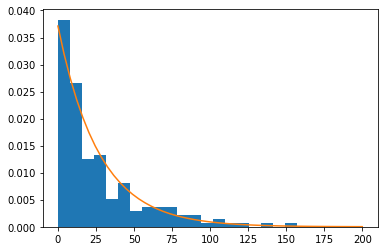

In [408]:
src = '221.194.47.redacted'
print(df[df.src == src].iloc[0][['user', 'password', 'client_version', 'city', 'country']])
dt = df[df.src == src].dt.dropna()
fit_dt(src, 200)
# plt.xlabel('inter-attack time')
# plt.ylabel('density')
# plt.legend()

user                                        root
password                                   wubao
client_version    SSH-2.0-OpenSSH_6.2p2 Ubuntu-6
city                                     Qingdao
country                                       CN
Name: 407, dtype: object


Text(0, 0.5, 'count')

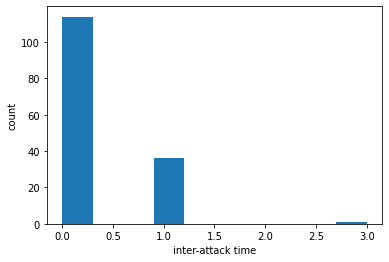

In [364]:
src = '223.99.60.redacted'
print(df[df.src == src].iloc[0][['user', 'password', 'client_version', 'city', 'country']])
dt = df[df.src == src].dt.dropna()

plt.hist(dt[dt <= 4])
plt.xlabel('inter-attack time')
plt.ylabel('count')

Text(0, 0.5, 'inter-attack time')

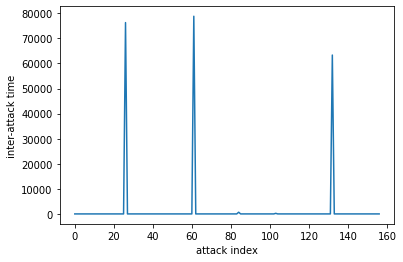

In [357]:
plt.plot(np.arange(len(dt)), dt)
plt.xlabel('attack index')
plt.ylabel('inter-attack time')

user                                        root
password                                   wubao
client_version    SSH-2.0-OpenSSH_6.2p2 Ubuntu-6
city                                    Nanchang
country                                       CN
Name: 519, dtype: object


Text(0, 0.5, 'count')

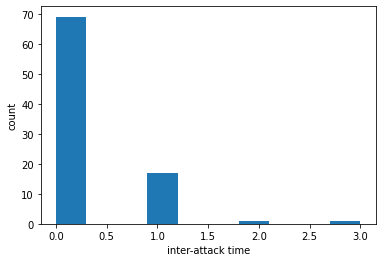

In [365]:
src = '218.65.30.redacted'
print(df[df.src == src].iloc[0][['user', 'password', 'client_version', 'city', 'country']])
dt = df[df.src == src].dt.dropna()

plt.hist(dt[dt <= 4])
plt.xlabel('inter-attack time')
plt.ylabel('count')

Text(0, 0.5, 'inter-attack time')

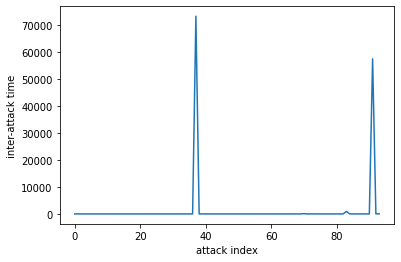

In [359]:
plt.plot(np.arange(len(dt)), dt)
plt.xlabel('attack index')
plt.ylabel('inter-attack time')

In [278]:
ss.ks_2samp(df[df.src == '218.65.30.redacted'].dt.dropna(), df[df.src == '223.99.60.redacted'].dt.dropna())

KstestResult(statistic=0.04052039571757691, pvalue=0.999871847653773)

Text(0, 0.5, 'density')

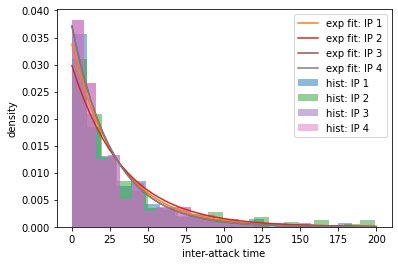

In [407]:
fit_dt('121.18.238.redacted', 200, a=.5)
fit_dt('221.194.44.redacted', 200, a=.5)
fit_dt('221.194.47.redacted', 200, a=.5)
fit_dt('221.194.47.redacted', 200, a=.5)
plt.legend([f'exp fit: IP {i}' for i in range(1,5)] + [f'hist: IP {i}' for i in range(1,5)])
plt.xlabel('inter-attack time')
plt.ylabel('density')

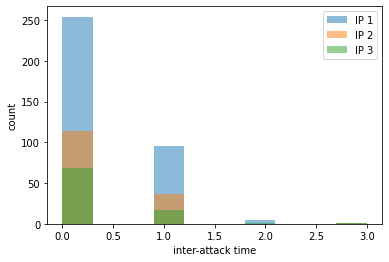

In [402]:
dt = df[df.src == '61.177.172.redacted'].dt.dropna()
plt.hist(dt[dt <= 4], alpha=.5, label='IP 1')

dt = df[df.src == '223.99.60.redacted'].dt.dropna()
plt.hist(dt[dt <= 4], alpha=.5, label='IP 2')

dt = df[df.src == '218.65.30.redacted'].dt.dropna()
plt.hist(dt[dt <= 4], alpha=.5, label='IP 3')

plt.xlabel('inter-attack time')
plt.ylabel('count')
plt.legend()

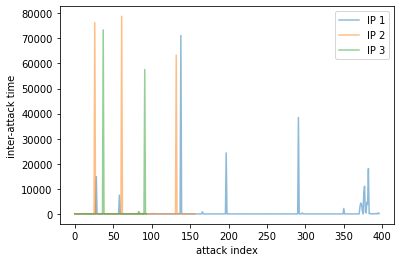

In [404]:
dt = df[df.src == '61.177.172.redacted'].dt.dropna()
plt.plot(np.arange(len(dt)), dt, alpha=.5, label='IP 1')

dt = df[df.src == '223.99.60.redacted'].dt.dropna()
plt.plot(np.arange(len(dt)), dt, alpha=.5, label='IP 2')

dt = df[df.src == '218.65.30.redacted'].dt.dropna()
plt.plot(np.arange(len(dt)), dt, alpha=.5, label='IP 3')

plt.xlabel('attack index')
plt.ylabel('inter-attack time')
plt.legend()